In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from spice import SpiceEstimator, SpiceDataset, SpiceConfig, BaseRNN, Agent
from weinhardt2025.utils.bandits import BanditsGeneral, create_dataset
from weinhardt2025.benchmarking.benchmarking_qlearning import QLearning

## General Experiment Setup

In [2]:
n_actions = 2
n_participants = 25
n_trials = 100
n_sessions = 4

### Specific experiment conditions per experiment

In [3]:
envs = []
envs.append(BanditsGeneral(
    n_arms=n_actions,
    init_reward_prob=(0.2, 0.8),    # -> easy learning task; no special effects; basic q-learning
    drift_rate=0,
    hazard_rate=0.1,
    reward_prob_correlation=0,
))

envs.append(BanditsGeneral(
    n_arms=n_actions,
    init_reward_prob=(0.2, 0.5),    # -> lower reward prob for better arm; enables choice perseverance
    drift_rate=0.,
    hazard_rate=0.1,
    reward_prob_correlation=0,
))

envs.append(BanditsGeneral(
    n_arms=n_actions,
    init_reward_prob=(0.4, 0.6),
    drift_rate=0.2,                 # -> drifting reward probabilities for both arms; enables gradual forgetting of unchosen arm  
    hazard_rate=0,
    reward_prob_correlation=0,
))

envs.append(BanditsGeneral(
    n_arms=n_actions,
    init_reward_prob=(0.4, 0.6),
    drift_rate=0.2,
    hazard_rate=0.,
    reward_prob_correlation=-0.5,  # -> as previous environment + correlated reward probabilities; enables counterfactual updates of unchosen arm
))

### Plotting differences between experiments in terms of reward probabilities over trials

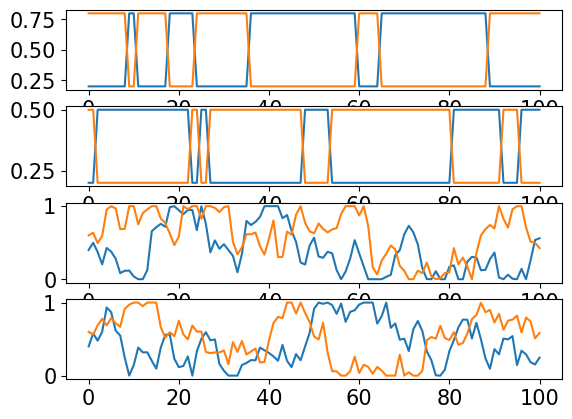

In [4]:
fig, axs = plt.subplots(nrows=4)
for i_env in range(len(envs)):
    for i_trial in range(n_trials):
        envs[i_env].step(0)
    reward_probs = np.stack(envs[i_env].history['reward_probs'])
    axs[i_env].plot(reward_probs)
    envs[i_env].new_sess()
plt.show()

## Setting up agents with specific sets of cognitive mechanisms for each experiment condition

In [5]:
agents = []

agents.append(Agent(
    QLearning(
        n_actions=n_actions,
        n_participants=n_participants,
        beta_reward=3.0,
        alpha_reward=0.7,  # -> higher learning rate because of more certain environment
        alpha_penalty=0.7,
        forget_rate=0.,
        beta_choice=0.,
    ), use_sindy=True, deterministic=False
))

agents.append(Agent(
    QLearning(
        n_actions=n_actions,
        n_participants=n_participants,
        beta_reward=3.0,
        alpha_reward=0.5,  # -> lower learning rate because of less certain environment
        alpha_penalty=0.5,
        forget_rate=0.,
        beta_choice=1.,  # -> choice perseverance because of lower reward probability for better arm
    ), use_sindy=True, deterministic=False
))

agents.append(Agent(
    QLearning(
        n_actions=n_actions,
        n_participants=n_participants,
        beta_reward=3.0,
        alpha_reward=0.5,
        alpha_penalty=0.5,
        forget_rate=0.3,  # -> forgetting of unchosen value because of unknown random drift of both arms  
        beta_choice=0.,
    ), use_sindy=True, deterministic=False
))

agents.append(Agent(
    QLearning(
        n_actions=n_actions,
        n_participants=n_participants,
        beta_reward=3.0,
        alpha_reward=0.5,
        alpha_penalty=0.5,
        forget_rate=0.3,  # -> same as previous agent + counterfactual update because of negative reward correlation 
        beta_choice=0.,
        counterfactual_learning=True,
    ), use_sindy=True, deterministic=False
))

### Showing agent handling and agent differences in terms of SINDy coefficients

In [6]:
print(f"Available modules: {agents[0].model.get_modules()}")
print("SINDy candidate terms per module:")
for module in agents[0].model.get_modules():
    print(f"\t{module}: {agents[0].model.sindy_candidate_terms[module]}")    
print("SINDy coefficients for basic Q-Learning:")
for module in agents[0].model.get_modules():
    print(f"\t{module}: {agents[0].model.sindy_coefficients[module][0, 0, 0]}")
print("SINDy coefficients for Q-Learning+Choice Perseverance:")
for module in agents[0].model.get_modules():
    print(f"\t{module}: {agents[1].model.sindy_coefficients[module][0, 0, 0]}")
    print("SINDy coefficients for Q-Learning+Forgetting:")
for module in agents[0].model.get_modules():
    print(f"\t{module}: {agents[2].model.sindy_coefficients[module][0, 0, 0]}")
print("SINDy coefficients for Q-Learning+Forgetting+Counterfactual Updating:")
for module in agents[0].model.get_modules():
    print(f"\t{module}: {agents[3].model.sindy_coefficients[module][0, 0, 0]}")

Available modules: ['value_reward_chosen', 'value_reward_not_chosen', 'value_choice']
SINDy candidate terms per module:
	value_reward_chosen: ['1', 'value_reward_chosen', 'reward', 'value_reward_chosen^2', 'value_reward_chosen*reward', 'reward^2']
	value_reward_not_chosen: ['1', 'value_reward_not_chosen', 'value_reward_not_chosen^2']
	value_choice: ['1', 'value_choice', 'choice', 'value_choice^2', 'value_choice*choice', 'choice^2']
SINDy coefficients for basic Q-Learning:
	value_reward_chosen: tensor([-0.0000, -0.7000,  2.1000, -0.0000,  0.0000, -0.0000])
	value_reward_not_chosen: tensor([0., -0., -0.])
	value_choice: tensor([ 0., -1.,  0., -0., -0., -0.])
SINDy coefficients for Q-Learning+Choice Perseverance:
	value_reward_chosen: tensor([-0.0000, -0.5000,  1.5000,  0.0000,  0.0000, -0.0000])
SINDy coefficients for Q-Learning+Forgetting:
	value_reward_not_chosen: tensor([0., -0., -0.])
SINDy coefficients for Q-Learning+Forgetting:
	value_choice: tensor([ 0., -1.,  1., -0.,  0., -0.])


## Data generation with each agent-experiment-pair

In [7]:
datasets = []
xs = torch.zeros((len(agents)*n_participants, n_trials, n_actions*2+3))
ys = torch.zeros((len(agents)*n_participants, n_trials, n_actions))

for i_agent in range(len(agents)):
    dataset_agent = create_dataset(
        agent=agents[i_agent],
        environment=envs[i_agent],
        n_trials=n_trials,
        n_sessions=n_participants,
        verbose=False,
    )[0]
    
    # adjust experiment_id
    dataset_agent.xs[..., -2] = i_agent
    
    xs[n_participants*i_agent:n_participants*(i_agent+1)] = dataset_agent.xs
    ys[n_participants*i_agent:n_participants*(i_agent+1)] = dataset_agent.ys

dataset = SpiceDataset(xs, ys)

Creating dataset...


100%|██████████| 25/25 [00:01<00:00, 18.74it/s]


Creating dataset...


100%|██████████| 25/25 [00:01<00:00, 19.46it/s]


Creating dataset...


100%|██████████| 25/25 [00:01<00:00, 19.20it/s]


Creating dataset...


100%|██████████| 25/25 [00:01<00:00, 16.16it/s]


In [8]:
print(dataset.xs.shape)  # -> shape: (n_participants*n_blocks_per_participant*n_experiments_per_participant, n_trials, features); features.shape -> (action_0, action_1, ..., reward_0, reward_1, ..., block_id, experiment_id, participant_id)
print(dataset.ys.shape) # -> shape: (n_participants*n_blocks_per_participant*n_experiments_per_participant, n_trials, n_actions)

torch.Size([100, 100, 7])
torch.Size([100, 100, 2])


## SPICE Setup

In [9]:
spice_config = SpiceConfig(
    library_setup = {
        'value_reward_chosen': ['reward'],                                              # --> n_terms = 6
        'value_reward_not_chosen': ['reward_chosen_success', 'reward_chosen_fail'],     # --> n_terms = 10
        'value_choice': ['choice'],                                                     # --> n_terms = 6
        },                                                                              # --> n_terms_total = 22
    memory_state={
            'value_reward': 0.,
            'value_choice': 0.,
            },
)


class SpiceModel(BaseRNN):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        dropout = 0.1
        embedding_size_experiment = 4
        
        # set up the participant-embedding layer
        self.participant_embedding = self.setup_embedding(self.n_participants, self.embedding_size, dropout=dropout)
        self.experiment_embedding = self.setup_embedding(self.n_experiments, embedding_size_experiment)

        # set up the submodules
        self.setup_module(key_module='value_reward_chosen', input_size=1+self.embedding_size+embedding_size_experiment, dropout=dropout)
        self.setup_module(key_module='value_reward_not_chosen', input_size=2+self.embedding_size+embedding_size_experiment, dropout=dropout)
        self.setup_module(key_module='value_choice', input_size=1+self.embedding_size+embedding_size_experiment, dropout=dropout)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        spice_signals = self.init_forward_pass(inputs, prev_state, batch_first)
        
        # manual feature extraction
        reward_chosen_success = spice_signals.rewards.sum(dim=-1, keepdim=True).repeat(1, 1, self.n_actions) == 1
        reward_chosen_fail = spice_signals.rewards.sum(dim=-1, keepdim=True).repeat(1, 1, self.n_actions) != 1
        
        # We compute now the participant embeddings and inverse noise temperatures before the for-loop because they are anyways time-invariant
        participant_embedding = self.participant_embedding(spice_signals.participant_ids)
        experiment_embedding = self.experiment_embedding(spice_signals.experiment_ids)
        
        for timestep in spice_signals.timesteps:
            
            # updates for value_reward
            self.call_module(
                key_module='value_reward_chosen',
                key_state='value_reward',
                action_mask=spice_signals.actions[timestep],
                inputs=(spice_signals.rewards[timestep]),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embedding,
                experiment_index=spice_signals.experiment_ids,
                experiment_embedding=experiment_embedding,
                )
            
            self.call_module(
                key_module='value_reward_not_chosen',
                key_state='value_reward',
                action_mask=1-spice_signals.actions[timestep],
                inputs=(
                    reward_chosen_success[timestep], 
                    reward_chosen_fail[timestep],
                    ),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embedding,
                experiment_index=spice_signals.experiment_ids,
                experiment_embedding=experiment_embedding,
                )
            
            # updates for value_choice
            self.call_module(
                key_module='value_choice',
                key_state='value_choice',
                action_mask=None,
                inputs=(spice_signals.actions[timestep]),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embedding,
                experiment_index=spice_signals.experiment_ids,
                experiment_embedding=experiment_embedding,
                )
            
            # Now keep track of the logit in the output array
            # spice_signals.logits[timestep] = self.state['value_reward'] * beta_reward + self.state['value_choice'] * beta_choice
            spice_signals.logits[timestep] = self.state['value_reward'] + self.state['value_choice']
            
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        spice_signals = self.post_forward_pass(spice_signals, batch_first)
        
        return spice_signals.logits, self.get_state()

In [ ]:
path_spice_model = 'spice.pkl'

estimator = SpiceEstimator(
    # meta parameters
    rnn_class=SpiceModel,
    spice_config=spice_config,
    n_actions=n_actions,
    n_participants=n_participants,
    n_experiments=len(envs),
    
    # training parameters
    epochs=1000,
    warmup_steps=1000//4,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    
    # sindy parameters
    sindy_weight=0.1,
    sindy_threshold=0.05,
    sindy_alpha=0.0001,
    sindy_cutoff_patience=100,
    sindy_epochs=2000,
    sindy_library_polynomial_degree=2,
    
    # additional generalization parameters
    bagging=True,
    scheduler=True,
    
    save_path_spice=path_spice_model,
    verbose=True,
)

In [11]:
estimator.fit(data=dataset.xs, targets=dataset.ys, data_test=dataset.xs, target_test=dataset.ys)


Training the RNN...
Epoch 1/10 --- L(Train): 2.1706443 --- L(Val, RNN): 1.0649184 --- L(Val, SINDy): 0.7204644 --- Time: 1.22s; --- Convergence: 5.32e-01; LR: 1.00e-02; Metric: inf; Bad epochs: 0/100
--------------------------------------------------------------------------------
SPICE Model (Coefficients: 22):
value_reward_chosen[t+1] = -0.003 1 + 1.001 value_reward_chosen[t] + -0.003 reward + -0.001 value_reward_chosen^2 + -0.0 value_reward_chosen*reward + -0.003 reward^2 
value_reward_not_chosen[t+1] = 0.005 1 + 0.999 value_reward_not_chosen[t] + 0.001 reward_chosen_success + 0.004 reward_chosen_fail + 0.001 value_reward_not_chosen^2 + 0.001 value_reward_not_chosen*reward_chosen_success + -0.002 value_reward_not_chosen*reward_chosen_fail + -0.0 reward_chosen_success^2 + 0.0 reward_chosen_success*reward_chosen_fail + 0.005 reward_chosen_fail^2 
value_choice[t+1] = -0.001 1 + 0.993 value_choice[t] + 0.004 choice + -0.01 value_choice^2 + -0.005 value_choice*choice + 0.004 choice^2 
--